# Data preprocessing for FIQA-Underexposure-Bias model

In [ ]:
import sys
sys.path.append('../')
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json
import csv

sys.path.append('/home/dasec-notebook/Thesis/OFIQ-Project/python')
from ofiq_zmq import OfiqZmq

from utils import multiclass_classification_utils 

%load_ext autoreload
%autoreload 2

In [ ]:
INPUT_FOLDER = "/home/dasec-notebook/Thesis/Datasets/mst-e_data/CSEC"
OUTPUT_FOLDER = "/home/dasec-notebook/Thesis/Datasets/mst-e_data/FIQA_CSEC"
shape_predictor_path = "/home/dasec-notebook/Thesis/skin_tone_estimation/shape_predictor_68_face_landmarks.dat"  # Download this file
OUTPUT_SIZE = 2048
TRANSFORM_SIZE = 4096
ENABLE_PADDING = True

# Process images
multiclass_classification_utils.process_images(INPUT_FOLDER, OUTPUT_FOLDER, OUTPUT_SIZE, shape_predictor_path, TRANSFORM_SIZE, ENABLE_PADDING)


Append a full path to the image

Needed because there are some images which have duplicate names and during the extraction their file names have been changed to include _1/_2

In [19]:

# Path to the directories
image_dir = '/home/dasec-notebook/Thesis/Datasets/CHROMA-FIT-Dataset/DATA_CROPPED_PORTRAIT2_illuminant_correction/exposure_color_correction'
input_csv = 'exposure_features/original/CHROMA-FIT_exposure_color_correction_predictions_predictions.csv'
output_csv = 'exposure_features/original/CHROMA-FIT_exposure_color_correction_predictions_predictions.csv'

# Load the CSV
df = pd.read_csv(input_csv)

full_paths = []

# Recursively map images to their folder paths
for _, row in df.iterrows():
    image_name = row['Image']
    image_found = False
    for root, dirs, files in os.walk(image_dir):
        if image_name in files:
            relative_path = os.path.relpath(root, image_dir)
            full_paths.append(f"{relative_path}/{image_name}")
            image_found = True
            break
    if not image_found:
        print(image_name)
        full_paths.append("NOT_FOUND")

# Add the new column to the DataFrame
df['Image'] = full_paths
df.to_csv(output_csv, index=False)

print(f"Updated CSV file has been saved to: {output_csv}")


DSC_0754_1.JPG
DSC_0918_1.JPG
DSC_1665_1.JPG
DSC_1717_1.JPG
DSC_1717_2.JPG
DSC_1726_1.JPG
DSC_1745_1.JPG
DSC_1754_1.JPG
Updated CSV file has been saved to: exposure_features/original/CHROMA-FIT_exposure_color_correction_predictions_predictions.csv


Plot the results

Interval 0.0-0.25


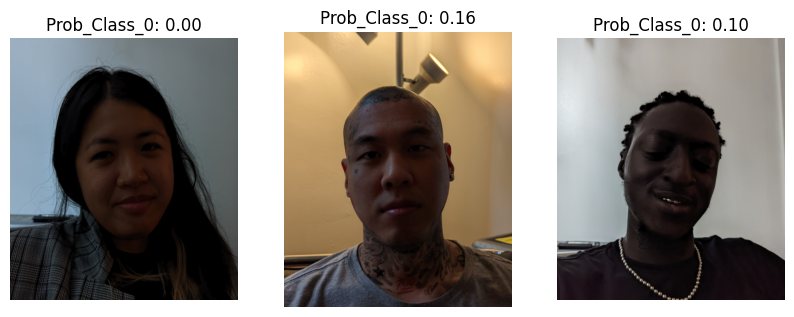

Interval 0.25-0.5


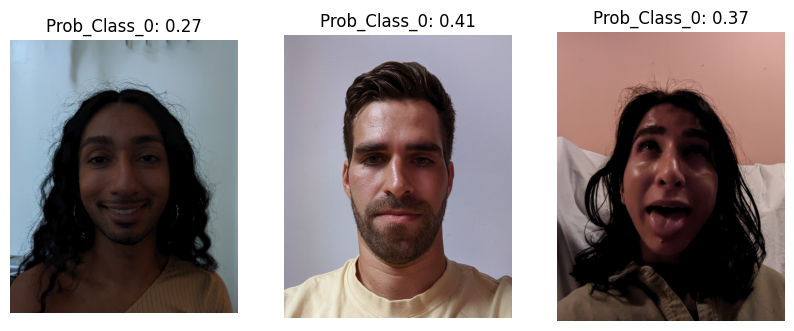

Interval 0.5-0.75


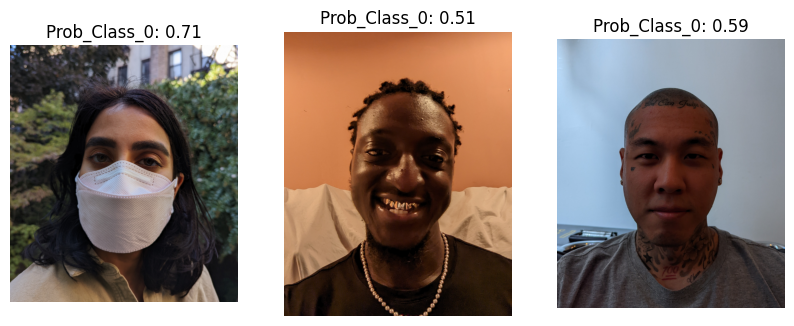

Interval 0.75-1.0


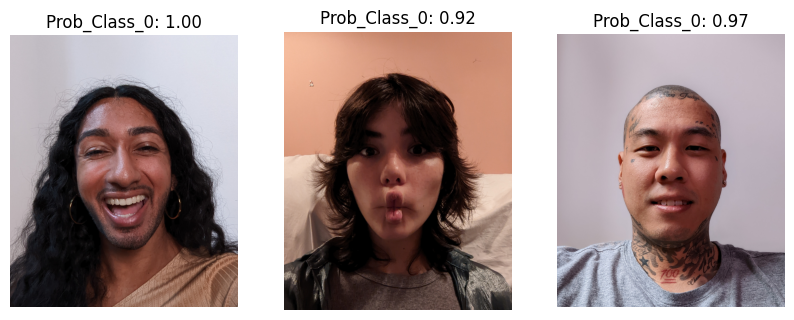

In [17]:
from pathlib import Path


image_root = "/home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait"
csv_file = '/home/dasec-notebook/Thesis/skin_tone_estimation/multiclass_classification/exposure_features/formatted/MST_predictions.csv'

df = pd.read_csv(csv_file)

# Define the intervals
# intervals = [(i / 10, (i + 2) / 10) for i in range(0, 10, 2)]  # [(0.0, 0.2), (0.2, 0.4), ..., (0.8, 1.0)]
intervals = [(i / 4, (i + 1) / 4) for i in range(4)]  # [(0.0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0)]


# Loop through each interval
for idx, (low, high) in enumerate(intervals):

    filtered = df[(df['Prob_Class_0'] >= low) & (df['Prob_Class_0'] < high)]
    sample = filtered.sample(min(3, len(filtered)))  # Take up to 2 samples
    
    print(f"Interval {low}-{high}")
    fig, axes = plt.subplots(1, len(sample), figsize=(10, 6))

    # Add images to subplots
    for j, (_, row) in enumerate(sample.iterrows()):
        image_path = os.path.join(image_root, row['Image'])
        img = Image.open(image_path)
        axes[j].imshow(img)
        axes[j].set_title(f"Prob_Class_0: {row['Prob_Class_0']:.2f}")
        axes[j].axis("off")
        

    plt.show()


OFIQ illuminanation uniformity feature

In [ ]:
ofiq_zmq = OfiqZmq('/home/dasec-notebook/Thesis/OFIQ-Project')

dataset_path = "//home/dasec-notebook/Thesis/Datasets/mst-e_data/mst-e_data_portrait_illuminant_correction/exposure_color_correction"
images_path = "../image_paths/MST.txt"
save_path = "exposure_features/OFIQ/MST_exposure_color_correction.csv"

exposure_df = pd.DataFrame(columns=["image_path", "illumination_uniformity"])

# load image paths
with open(images_path, 'r') as f:
    image_paths = f.readlines()

for image_path in image_paths:

    try:
        image= os.path.join(dataset_path, image_path.strip())
        result = ofiq_zmq.process_image(image)
        illumination_uniformity = result["quality_assessments"][67].raw_score

        # Append the results to the DataFrame using pd.concat instead of append
        exposure_df = pd.concat([exposure_df, pd.DataFrame({"image_path": [image_path.strip()], "illumination_uniformity": [illumination_uniformity]})], ignore_index=True)
    except Exception as e:
        print(f"Error processing image: {image_path}")

exposure_df.to_csv(save_path, index=False)


Append OFIQ exposure to training data files

In [21]:
# Paths to input files
json_file_path = "training_data/v1/MST_data.json"  
csv_file_path = "exposure_features/OFIQ/MST.csv"  
output_json_path = "training_data/v2/MST_data.json" 

with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

# Load the CSV data into a dictionary
illumination_data = {}
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        dir_and_file = row["image_path"]
        illumination_value = float(row["illumination_uniformity"])
        illumination_data[dir_and_file] = illumination_value

# Add illumination_uniformity to the JSON data
for dir_id, dir_data in data.items():
    for image_id in dir_data.keys():
        if image_id == "MST_value":
            continue
        
        csv_key = f"{dir_id}/{image_id}"
        if csv_key in illumination_data.keys():
            dir_data[image_id]["OFIQ_illumination_uniformity"] = illumination_data[csv_key]

# Save the updated JSON data to a new file
with open(output_json_path, 'w') as output_file:
    json.dump(data, output_file, indent=4)

print(f"Updated JSON saved to {output_json_path}")


Updated JSON saved to training_data/v2/MST_data.json


# Combine all class values in one json file to be used in multiclass classification

In [ ]:
import json
import csv
from pathlib import Path

# Paths to your input files
# cheek_rgb_path = "../baseline/results/cheek_colors_extracted/MST_exposure_color_correction.json"
# sclera_rgb_path = "../sclera_segmentation/results/MST_exposure_color_correction_sclera_RGB.json"
# exposure_csv_path = "exposure_features/formatted/MST_exposure_color_correction_predictions.csv"

# combined_output_path = "training_data/MST_exposure_color_correction_data.json"

cheek_rgb_path = "../baseline/results/cheek_colors_extracted/CHROMA-FIT_exposure_color_correction_outdoor.json"
sclera_rgb_path = "../sclera_segmentation/results/CHROMA-FIT_exposure_color_correction_sclera_RGB.json"
exposure_csv_path = "exposure_features/formatted/CHROMA-FIT_exposure_color_correction_predictions.csv"
ground_truth_path = "../image_paths/ground_truth_CHROMA-FIT_forehead.csv"

combined_output_path = "training_data/CHROMA-FIT_exposure_color_correction_outdoor_data.json"

# NOTE: for MST dataset only
MST_SUBJECT_MAPPING = {
    'subject_18': 1,
    'subject_17': 8,
    'subject_16': 1,
    'subject_15': 3,
    'subject_14': 6,
    'subject_13': 2,
    'subject_12': 10,
    'subject_11': 5,
    'subject_10': 9,
    'subject_9': 4,
    'subject_8': 2,
    'subject_7': 4,
    'subject_6': 5,
    'subject_5': 7,
    'subject_4': 9,
    'subject_3': 6,
    'subject_2': 8,
    'subject_1': 2,
    'subject_0': 3
}


# NOTE: just for CHROMA-FIT dataset
ground_truth_avg_data = {}
with open(ground_truth_path, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        subject_id = f"{int(row['ID']):05d}"  # Convert to five-digit format
        ground_truth_avg = int(row["Ground_Truth_Avg"])
        ground_truth_avg_data[subject_id] = ground_truth_avg

# Load JSON data
with open(sclera_rgb_path, "r") as sclera_file:
    sclera_data = json.load(sclera_file)

with open(cheek_rgb_path, "r") as csec_file:
    cheek_rgb = json.load(csec_file)

# Load CSV data
FIQA_exposure = {}
with open(exposure_csv_path, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        # Extract relevant columns
        image = row["Image"].split("/")[-1]  # Get the file name only
        prob_class_0 = float(row["Prob_Class_0"])
        FIQA_exposure[image] = {"Prob_Class_0": prob_class_0}

combined_results = {}

for subject, images in cheek_rgb.items():
    combined_results[subject] = {}
    # mst_value = MST_SUBJECT_MAPPING.get(subject, None)  # NOTE: For MST dataset only
    mst_value = ground_truth_avg_data.get(subject, None)  # NOTE: For CHROMA-FIT dataset only
    combined_results[subject]["MST_value"] = mst_value
    
    for image, csec_values in images.items():
        combined_results[subject][image] = {
            "CSEC_cheek_colors": csec_values
        }

        # Add CSEC cheek colors
        if subject in sclera_data and image in sclera_data[subject]:
            combined_results[subject][image]["sclera_RGB"] = sclera_data[subject][image]

        # Add CHROMA-FIT predictions
        if image in FIQA_exposure:
            combined_results[subject][image]["FIQA_exposure"] = FIQA_exposure[image]

# Save the combined results to a JSON file
with open(combined_output_path, "w") as output_file:
    json.dump(combined_results, output_file, indent=4)

print(f"Combined results saved to {combined_output_path}")
